In [56]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
from copy import deepcopy

# Dataset

In [57]:
num_slots = 8

# Electricity Price Generation

In [58]:
ep_mx_q1 = 35
ep_mx_q2 = 35
ep_mx_q3 = 30
ep_mx_q4 = 20
ep_k = 5
min_price = 7

<Figure size 432x288 with 0 Axes>

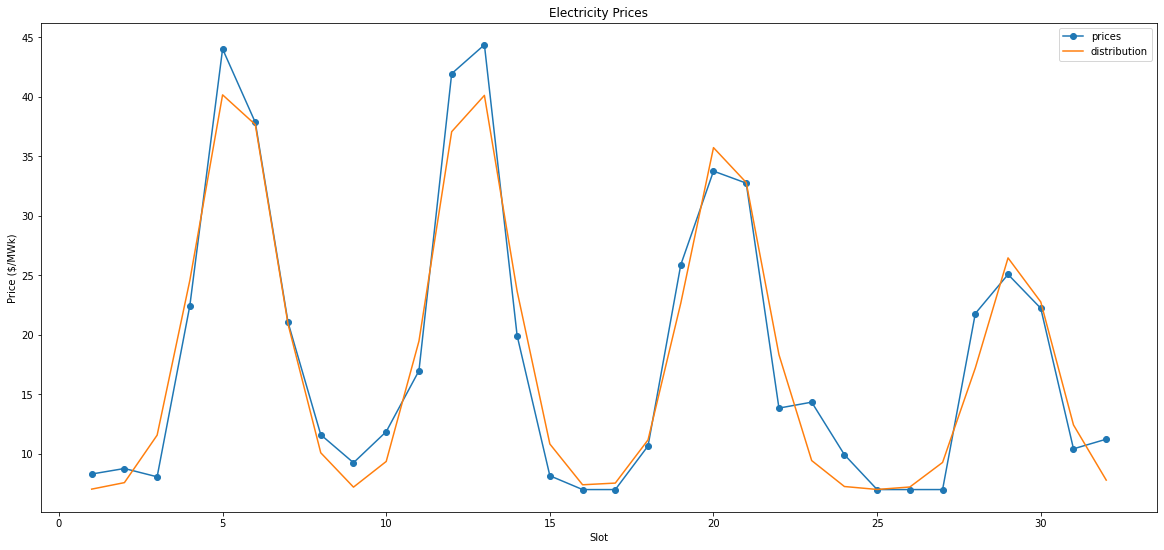

In [59]:
num_points = 1000

mu, sigma = 0, 1.0/(np.sqrt(2 * np.pi) * ep_mx_q1)
s = np.random.normal(mu, sigma, num_points)
count, bins, ignored = plt.hist(s, num_slots, density=True)
plt.clf()
electricity_prices = [max(0, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) + random.uniform(-ep_k, ep_k)) for i in bins[:-1]]
distribution = [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) for i in bins[:-1]]

mu, sigma = 0, 1.0/(np.sqrt(2 * np.pi) * ep_mx_q2)
s = np.random.normal(mu, sigma, num_points)
count, bins, ignored = plt.hist(s, num_slots, density=True)
plt.clf()
electricity_prices += [max(0, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) + random.uniform(-ep_k, ep_k)) for i in bins[:-1]]
distribution += [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) for i in bins[:-1]]

mu, sigma = 0, 1.0/(np.sqrt(2 * np.pi) * ep_mx_q3)
s = np.random.normal(mu, sigma, num_points)
count, bins, ignored = plt.hist(s, num_slots, density=True)
plt.clf()
electricity_prices += [max(0, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) + random.uniform(-ep_k, ep_k)) for i in bins[:-1]]
distribution += [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) for i in bins[:-1]]

mu, sigma = 0, 1.0/(np.sqrt(2 * np.pi) * ep_mx_q4)
s = np.random.normal(mu, sigma, num_points)
count, bins, ignored = plt.hist(s, num_slots, density=True)
plt.clf()
electricity_prices += [max(0, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) + random.uniform(-ep_k, ep_k)) for i in bins[:-1]]
distribution += [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (i - mu)**2 / (2 * sigma**2)) for i in bins[:-1]]

electricity_prices = [i + min_price for i in electricity_prices]
distribution = [i + min_price for i in distribution]

slots = range(1, 4*num_slots+1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(9)
plt.title("Electricity Prices")
plt.xlabel("Slot")
plt.ylabel("Price ($/MWk)")
plt.plot(slots, electricity_prices, "-o", label = "prices")
plt.plot(slots, distribution, label = "distribution")
plt.legend()
plt.show()

# EAQR: Parallelization

Repeated Game formulation

Fully co-operative scenario where the agents try to maximize the global Q value from previous step while accounting for power limit.

**Additional Goal (Cooperation)**: To account for safety and ensure that power consumption doesn't exceed a limit at a particular timeslot. Previous solution doesn't account for such case and might give a solution where all agents are 'on' at a timeslot together, which may not be desirable.

### Let us first look at small problem and see how EAQR applies to it in this scenario.

We want to get maimum global immediate reward at timeslot t=6 and appliances are 'AC1' and 'L2'.

In [60]:
states = []
for i in range(1, num_slots + 1):
    states.append((electricity_prices[i-1], 0))

states

[(8.305050342588999, 0),
 (8.76835260937954, 0),
 (8.07134664084229, 0),
 (22.45533419072894, 0),
 (44.006077625432155, 0),
 (37.83385351835567, 0),
 (21.037542453445113, 0),
 (11.60539825658968, 0)]

In [61]:
app_data = [['AC1', 1.0, [1.0, 1.4]], ['L2', 0.4, [0.6, 0.8]]]
agts = ['AC1', 'L2']
app_df = pd.DataFrame(app_data, columns=['name', 'dc', 'actions'])
app_df

,name,dc,actions
0,AC1,1.0,"[1.0, 1.4]"
1,L2,0.4,"[0.6, 0.8]"


In [72]:
def get_small_reward_with_DR(t, agent, act):
    reward = 0.0
    cost = 0.0
    max_pow = app_df.loc[app_df['name'] == agent]['actions'].tolist()[0][-1]
    dc = max_pow = app_df.loc[app_df['name'] == agent]['dc'].tolist()[0]
    reward = ((-states[t][0] * max(0, (act))) - (dc * math.pow(max_pow - act, 2)))
    cost = (-states[t][0] * max(0, (act)))
    if agent == 'AC1' and t == 1 and act == 1.0:
        reward = 0.0000000
    if agent == 'L2' and t == 1 and act == 0.8:
        reward = 0.0000000
    return round(reward, 6), cost, act

def get_small_reward_without_DR(t, agent, act):
    reward = 0.0
    cost = 0.0
    reward = (-states[t][0] * max(0, (act)))
    cost = (-states[t][0] * max(0, (act)))
    if agent == 'AC1' and t == 1 and act == 1.0:
        reward = 0.0000000
    if agent == 'L2' and t == 1 and act == 0.8:
        reward = 0.0000000
    return round(reward, 6), cost, act

def get_small_global_reward_with_DR(t, actions, penalty_factor, limit):
    global_reward = 0
    total_power = 0
    for agent in agts:
        act = actions[agent]
        global_reward += get_small_reward_with_DR(t, agent, act)[0]
        total_power += get_small_reward_with_DR(t, agent, act)[2]
    if total_power > limit:
        global_reward -= penalty_factor * (total_power - limit)
    return global_reward

def get_small_global_reward_without_DR(t, actions, penalty_factor, limit):
    global_reward = 0
    total_power = 0
    for agent in agts:
        act = actions[agent]
        global_reward += get_small_reward_without_DR(t, agent, act)[0]
        total_power += get_small_reward_without_DR(t, agent, act)[2]
    if total_power > limit:
        global_reward -= penalty_factor * (total_power - limit)
    return global_reward

In [73]:
penalty = 0.9
lmt = 2
num_timeslots = num_slots

In [74]:
agents = agts

In [75]:
from tabulate import tabulate
for t in range(num_timeslots):
    print('Slot: ', t)
    mydata = [
        ['AC1-action1: 1.0', get_small_global_reward_with_DR(t, {'AC1': 1.0, 'L2': 0.6}, penalty, lmt), get_small_global_reward_with_DR(t, {'AC1': 1.0, 'L2': 0.8}, penalty, lmt)],
        ['AC1-action2: 1.4', get_small_global_reward_with_DR(t, {'AC1': 1.4, 'L2': 0.6}, penalty, lmt), get_small_global_reward_with_DR(t, {'AC1': 1.4, 'L2': 0.8}, penalty, lmt)],
    ]
    
    # create header
    head = ['Payoffs', 'L2-action1: 0.6', 'L2-action2: 0.8']
    
    # display table
    print(tabulate(mydata, headers=head, tablefmt="grid"))


Slot:  0
+------------------+-------------------+-------------------+
| Payoffs          |   L2-action1: 0.6 |   L2-action2: 0.8 |
+==================+===================+===================+
| AC1-action1: 1.0 |          -13.3041 |          -15.0131 |
+------------------+-------------------+-------------------+
| AC1-action2: 1.4 |          -16.7861 |          -18.6751 |
+------------------+-------------------+-------------------+
Slot:  1
+------------------+-------------------+-------------------+
| Payoffs          |   L2-action1: 0.6 |   L2-action2: 0.8 |
+==================+===================+===================+
| AC1-action1: 1.0 |          -5.27701 |            0      |
+------------------+-------------------+-------------------+
| AC1-action2: 1.4 |         -17.7127  |          -12.6157 |
+------------------+-------------------+-------------------+
Slot:  2
+------------------+-------------------+-------------------+
| Payoffs          |   L2-action1: 0.6 |   L2-action2: 0.8

In [76]:
max_games = 10000
num_games = 50
alpha = 0.3
eps = 0.3

recomm = {}
avg_time = 0

for t in range(num_timeslots):
    start = time.time()
    recomm[t] = {}
    freq = {}
    Q = {}
    p = {}
    immediate_local_rewards = {}
    my_action_history = {}
    for agent in agts:
        my_action_history[agent] = {}
        freq[agent] = {}
        Q[agent] = {}
        p[agent] = {}
    flag = 0
    game_count = -1
    max_immediate_local_reward = float('-inf')
    converged = 0
    for agent in agts:
        recomm[t][agent] = None
        actions = app_df.loc[app_df['name'] == agent]['actions'].tolist()[0]
        for act in actions:
            freq[agent][act] = 0
            Q[agent][act] = random.random()
            p[agent][act] = 0 

    for game in range(max_games):  
        game_count += 1
        immediate_local_rewards[game_count] = {}
        for agent in agts:
            immediate_local_rewards[game_count][agent] = {}  
            actions = app_df.loc[app_df['name'] == agent]['actions'].tolist()[0]  
            sum_Q = 0
            for a in actions:
                sum_Q += Q[agent][a]
            probs = []
            for act in actions:
                prob_list = [1/len(actions), Q[agent][act]/sum_Q]
                p[agent][act] = random.choices(prob_list, weights=(eps, 1-eps))[0]
                probs.append(p[agent][act])
            probs = [int(i*1000) for i in probs]
            action = random.choices(actions, weights=tuple(probs))[0]
            my_action_history[agent][game_count] = action
            immediate_local_rewards[game_count][agent]['reward'] = get_small_reward_with_DR(t, agent, action)[0]
            immediate_local_rewards[game_count][agent]['action'] = get_small_reward_with_DR(t, agent, action)[2]
            if game_count == num_games:
                converged = 1
                for a in actions:
                    num_act_in_last_ns = 0
                    num_max_in_last_ns = 0
                    for game_no in range(num_games):
                        if my_action_history[agent][game_no] == a:
                            num_act_in_last_ns += 1
                            player_actions = {}
                            for ag in agts:
                                player_actions[ag] = immediate_local_rewards[game_no][ag]['action']
                            temp = get_small_global_reward_with_DR(t, player_actions, penalty, lmt)
                            # print(max_immediate_local_reward, temp, player_actions)
                            if abs(temp - max_immediate_local_reward) < 0.0001:
                                num_max_in_last_ns += 1
                            elif temp > max_immediate_local_reward:
                                max_immediate_local_reward = temp
                                num_max_in_last_ns = 0
                    if num_act_in_last_ns > 0:
                        freq[agent][a] = num_max_in_last_ns / num_act_in_last_ns
                    if abs(alpha * (freq[agent][a] - Q[agent][a])) > 0.001:
                        converged = 0
                    Q[agent][a] = Q[agent][a] + alpha * (freq[agent][a] - Q[agent][a])
                    flag = 1
        if flag == 1:
            if converged == 1:
                print('converged', game)
                break
            game_count = -1
            flag = 0
            for ag in agents:
                my_action_history[agent] = {}

    for a in agts:
        recomm[t][a] = max(Q[a], key=Q[a].get)
    end = time.time()
    avg_time += (end-start)
print('Average Recommendation Time: ', avg_time/num_timeslots)

converged 3926
converged 2396
converged 1886
converged 4028
converged 4079
converged 1019
converged 815
converged 815
Average Recommendation Time:  29.574256390333176


In [77]:
recomm

{0: {'AC1': 1.0, 'L2': 0.6},
 1: {'AC1': 1.0, 'L2': 0.8},
 2: {'AC1': 1.0, 'L2': 0.6},
 3: {'AC1': 1.0, 'L2': 0.6},
 4: {'AC1': 1.0, 'L2': 0.6},
 5: {'AC1': 1.0, 'L2': 0.6},
 6: {'AC1': 1.0, 'L2': 0.6},
 7: {'AC1': 1.0, 'L2': 0.6}}

Recommendations converge to solution giving maxmimum power penalty incorporated global immediate reward as expected. The power penalty could not have been incorporated in the previous multi agent Q learning setting. However, this algorithm might be used in combination with the Q learning method to maximize expected global power penalised reward instead of the immediate global power penalized reward. As the number of appliances increase (single or multiple homes), even though the state space remains same, action space can increase exponentially and hence might need deep learning methods for vaue function approximation.

In [81]:
app_data = [['AC1', 1.0, [1.0, 1.4]], ['AC2', 1.0, [1.0, 1.4]], ['AC3', 1.0, [1.0, 1.4]], ['AC4', 1.0, [1.0, 1.4]],  ['AC5', 1.0, [1.0, 1.4]],
            ['L1', 0.4, [0.6, 0.8]], ['L2', 0.4, [0.6, 0.8]], ['L3', 0.4, [0.6, 0.8]], ['L4', 0.4, [0.6, 0.8]]]
agts = ['AC1', 'AC2', 'AC3', 'AC4', 'AC5', 'L1', 'L2', 'L3', 'L4']
app_df = pd.DataFrame(app_data, columns=['name', 'dc', 'actions'])

max_games = 10000
num_games = 50
alpha = 0.3
eps = 0.3

recomm = {}
avg_time = 0

num_timeslots = 1

for t in range(num_timeslots):
    start = time.time()
    recomm[t] = {}
    freq = {}
    Q = {}
    p = {}
    immediate_local_rewards = {}
    my_action_history = {}
    for agent in agts:
        my_action_history[agent] = {}
        freq[agent] = {}
        Q[agent] = {}
        p[agent] = {}
    flag = 0
    game_count = -1
    max_immediate_local_reward = float('-inf')
    converged = 0
    for agent in agts:
        recomm[t][agent] = None
        actions = app_df.loc[app_df['name'] == agent]['actions'].tolist()[0]
        for act in actions:
            freq[agent][act] = 0
            Q[agent][act] = random.random()
            p[agent][act] = 0 

    for game in range(max_games):  
        game_count += 1
        immediate_local_rewards[game_count] = {}
        for agent in agts:
            immediate_local_rewards[game_count][agent] = {}  
            actions = app_df.loc[app_df['name'] == agent]['actions'].tolist()[0]  
            sum_Q = 0
            for a in actions:
                sum_Q += Q[agent][a]
            probs = []
            for act in actions:
                prob_list = [1/len(actions), Q[agent][act]/sum_Q]
                p[agent][act] = random.choices(prob_list, weights=(eps, 1-eps))[0]
                probs.append(p[agent][act])
            probs = [int(i*1000) for i in probs]
            action = random.choices(actions, weights=tuple(probs))[0]
            my_action_history[agent][game_count] = action
            immediate_local_rewards[game_count][agent]['reward'] = get_small_reward_with_DR(t, agent, action)[0]
            immediate_local_rewards[game_count][agent]['action'] = get_small_reward_with_DR(t, agent, action)[2]
            if game_count == num_games:
                converged = 1
                for a in actions:
                    num_act_in_last_ns = 0
                    num_max_in_last_ns = 0
                    for game_no in range(num_games):
                        if my_action_history[agent][game_no] == a:
                            num_act_in_last_ns += 1
                            player_actions = {}
                            for ag in agts:
                                player_actions[ag] = immediate_local_rewards[game_no][ag]['action']
                            temp = get_small_global_reward_with_DR(t, player_actions, penalty, lmt)
                            # print(max_immediate_local_reward, temp, player_actions)
                            if abs(temp - max_immediate_local_reward) < 0.0001:
                                num_max_in_last_ns += 1
                            elif temp > max_immediate_local_reward:
                                max_immediate_local_reward = temp
                                num_max_in_last_ns = 0
                    if num_act_in_last_ns > 0:
                        freq[agent][a] = num_max_in_last_ns / num_act_in_last_ns
                    if abs(alpha * (freq[agent][a] - Q[agent][a])) > 0.001:
                        converged = 0
                    Q[agent][a] = Q[agent][a] + alpha * (freq[agent][a] - Q[agent][a])
                    flag = 1
        if flag == 1:
            if converged == 1:
                print('converged', game)
                break
            game_count = -1
            flag = 0
            for ag in agents:
                my_action_history[agent] = {}

    for a in agts:
        recomm[t][a] = max(Q[a], key=Q[a].get)
    end = time.time()
    avg_time += (end-start)
print('Average Recommendation Time: ', avg_time/num_timeslots)

converged 1580
Average Recommendation Time:  275.69193816185


In [82]:
recomm

{0: {'AC1': 1.0,
  'AC2': 1.0,
  'AC3': 1.0,
  'AC4': 1.0,
  'AC5': 1.0,
  'L1': 0.6,
  'L2': 0.6,
  'L3': 0.6,
  'L4': 0.6}}

**Extension: Maximizing global expected power penalised reward instead of immediate reward.**